# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
import os 
# os.environ['LD_LIBRARY_PATH']='$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/'
# os.environ['LD_LIBRARY_PATH']='/home/jan/anaconda3/envs/tf/lib/'
# os.environ['PATH']='/home/jan/.vscode-server/bin/5235c6bb189b60b01b1f49062f4ffa42384f8c91/bin/remote-cli:/home/jan/anaconda3/bin:/home/jan/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/usr/lib/wsl/lib:/mnt/c/Windows/system32:/mnt/c/Windows:/mnt/c/Windows/System32/Wbem:/mnt/c/Windows/System32/WindowsPowerShell/v1.0:/mnt/c/Windows/System32/OpenSSH:/mnt/c/Program Files/dotnet:/mnt/c/Program Files (x86)/NVIDIA Corporation/PhysX/Common:/mnt/c/Users/janmo/AppData/Local/Microsoft/WindowsApps:/mnt/c/Users/janmo/AppData/Local/Programs/Microsoft VS Code/bin:/snap/bin'
os.environ

environ{'SHELL': '/bin/bash',
        'COLORTERM': 'truecolor',
        'WSL2_GUI_APPS_ENABLED': '1',
        'TERM_PROGRAM_VERSION': '1.74.0',
        'CONDA_EXE': '/home/jan/anaconda3/bin/conda',
        '_CE_M': '',
        'WSL_DISTRO_NAME': 'Ubuntu',
        'NAME': 'XPS-17',
        'PWD': '/home/jan/code_projects/neural-network-analog-needle-readout',
        'LOGNAME': 'jan',
        'CONDA_PREFIX': '/home/jan/anaconda3/envs/tf',
        'VSCODE_GIT_ASKPASS_NODE': '/home/jan/.vscode-server/bin/5235c6bb189b60b01b1f49062f4ffa42384f8c91/node',
        'HOME': '/home/jan',
        'LANG': 'C.UTF-8',
        'WSL_INTEROP': '/run/WSL/13324_interop',
        'LS_COLORS': 'rs=0:di=01;34:ln=01;36:mh=00:pi=40;33:so=01;35:do=01;35:bd=40;33;01:cd=40;33;01:or=40;31;01:mi=00:su=37;41:sg=30;43:ca=30;41:tw=30;42:ow=34;42:st=37;44:ex=01;32:*.tar=01;31:*.tgz=01;31:*.arc=01;31:*.arj=01;31:*.taz=01;31:*.lha=01;31:*.lz4=01;31:*.lzh=01;31:*.lzma=01;31:*.tlz=01;31:*.txz=01;31:*.tzo=01;31:*.t7z=01;31:

In [2]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "ana1100s3"   # Used for tflite Filename

##########################################################################



import os
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import math
from PIL import Image 
import hashlib
import random


%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# try:
#     # Disable all GPUS
#     tf.config.set_visible_devices([], 'GPU')
#     visible_devices = tf.config.get_visible_devices()
#     for device in visible_devices:
#         assert device.device_type != 'GPU'
# except:
#     # Invalid device or cannot modify virtual devices once initialized.
#     pass

2022-12-10 01:13:41.574382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-10 01:13:41.947932: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-10 01:13:42.838372: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jan/anaconda3/envs/tf/lib/
2022-12-10 01:13:42.838505: W tensorflow/compiler/xla

In [3]:
tf.config.list_physical_devices('GPU')

2022-12-10 01:13:44.516190: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-10 01:13:44.574879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-10 01:13:44.575089: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [4]:
Input_dir='data_resize_all'

files = sorted(glob.glob(Input_dir + '/*.*'))
X = []
y = []
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []
hashes = {}

for fname in files:
    img = Image.open(fname)
    # store hash for duplicate checking later on
    hash=hashlib.sha256(img.tobytes()).hexdigest()
    hashes[hash]=hashes.get(hash,[])
    hashes[hash].append(fname)

    img = np.array(img, dtype="float32")
    img = np.reshape(img, (32,32,3))
    base = os.path.basename(fname)
    target_number = (float(base[0:3])) / 10


    X.append(img)
    y.append(target_number)

    # # split train, val and test set more robustly
    if int(base[0:3].replace('.',''))%10<7: #70% in training set
        # if target is even then add to training set
        X_train.append(img)
        y_train.append(target_number)
    elif int(base[0:3].replace('.',''))%10==7:
        # add to val set
        X_val.append(img)
        y_val.append(target_number)
    elif int(base[0:3].replace('.',''))%10>7:
        # add to test set
        X_test.append(img)
        y_test.append(target_number)


X_train, y_train = shuffle(X_train, y_train)


for obj in [X, X_train, X_val, X_test]:
    print(len(obj))

6314
4580
522
1212


In [5]:
# check for duplicate images
for hash in hashes:
    if len(hashes[hash])>1:
        print(hashes[hash])

In [6]:
def target_to_trig(targets):
    '''
    converts the target vector (between 0 and 1 ) to sin, cos
    '''
    target_sin = np.sin(targets * math.pi * 2)
    target_cos = np.cos(targets * math.pi * 2)
    return np.vstack([target_sin, target_cos]).transpose()

def trig_to_target(trigs):
    '''
    converts vector of (sin,cos) pairs to vector of targets (between 0 and 1 )
    '''    
    return (np.arctan2(trigs[:,0], trigs[:,1])/(2*math.pi)) % 1

assert all(trig_to_target(target_to_trig(np.array([0,0.3,0.5,0.7,1])))==np.array([0,0.3,0.5,0.7,1]))

In [7]:
def augment(imgs, targets, n):
    '''create new datapoints by rotating the existing image n times and flipping'''
    X_aug=[]
    y_aug=[]
    for dt in random.sample(range(1,100),n):
        newtargets=(targets + dt/100*np.ones(len(targets)))%1 # 0<target<1 
        newimgs=tfa.image.rotate(imgs,-dt/100* math.pi * 2, fill_mode='nearest')
        X_aug.extend(newimgs)
        y_aug.extend(newtargets)
    X_aug.extend(imgs)
    y_aug.extend(targets)

    # flip images
    X_aug.extend(tf.image.flip_left_right(imgs))
    y_aug.extend(np.ones(len(targets))-targets)

    return X_aug,y_aug

X_train, y_train = augment(X_train, y_train,3)

2022-12-10 01:14:09.872584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-10 01:14:09.875251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-10 01:14:09.875360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-10 01:14:09.875391: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0

In [8]:
X = np.array(X)
y = target_to_trig(np.array(y))
X_train = np.array(X_train)
y_train = target_to_trig(np.array(y_train))
X_val = np.array(X_val)
y_val = target_to_trig(np.array(y_val))
X_test = np.array(X_test)
y_test = target_to_trig(np.array(y_test))

for obj in [X, X_train, X_val, X_test]:
    print(obj.shape)

(6314, 32, 32, 3)
(22900, 32, 32, 3)
(522, 32, 32, 3)
(1212, 32, 32, 3)


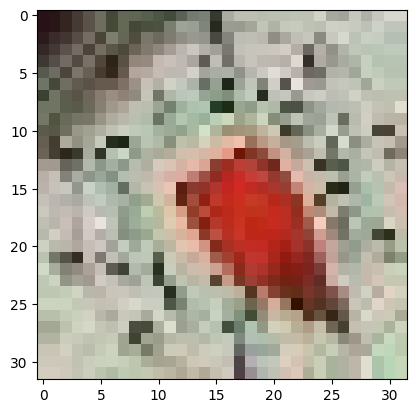

0.3900000000000001


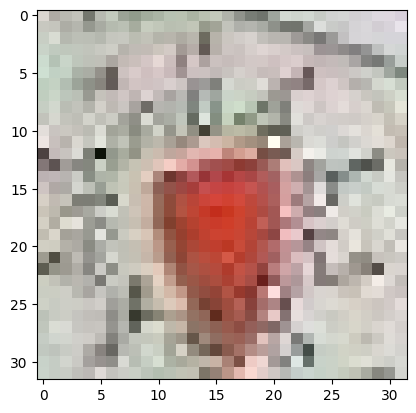

0.47


In [9]:
for img,label in random.sample(list(zip(X_train,y_train)),2):
    plt.imshow(np.array(img, dtype="int"))
    plt.show()
    (sin,cos)=label
    print((np.arctan2(sin,cos)/(2*math.pi)) % 1)

### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [10]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.BatchNormalization(input_shape=(32, 32, 3)),
        tf.keras.layers.Conv2D(
            32, (5, 5), input_shape=(32, 32, 3), padding="same", activation="relu"
        ),
        tf.keras.layers.MaxPool2D(pool_size=(4, 4)),
        # x = tf.keras.layers.Dropout(0.15)(x)
        tf.keras.layers.Conv2D(16, (5, 5), padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(pool_size=(4, 4)),
        tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        # tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation="relu"),
        # tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(2),
    ]
)
model.compile(
    loss=tf.keras.losses.mean_squared_error,
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95),
    metrics=["accuracy"],
)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 32, 32, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          12816     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 16)         0         
 2D)                                                             
                                                        

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is split into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [12]:
Batch_Size = 256
epochs = 15
Shift_Range = 3
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range],
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range])

train_iterator = datagen.flow(X_train, y_train, batch_size=Batch_Size)
validation_iterator = datagen.flow(X_val, y_val, batch_size=Batch_Size)
history = model.fit(train_iterator, validation_data = validation_iterator, epochs = epochs)


Epoch 1/15
90/90 [==============================] - 10s 103ms/step - loss: 0.1208 - accuracy: 0.8859 - val_loss: 0.0747 - val_accuracy: 0.9636
Epoch 2/15
90/90 [==============================] - 9s 101ms/step - loss: 0.0670 - accuracy: 0.9328 - val_loss: 0.0615 - val_accuracy: 0.9559
Epoch 3/15
90/90 [==============================] - 9s 100ms/step - loss: 0.0499 - accuracy: 0.9387 - val_loss: 0.0490 - val_accuracy: 0.9713
Epoch 4/15
90/90 [==============================] - 44s 496ms/step - loss: 0.0393 - accuracy: 0.9494 - val_loss: 0.0377 - val_accuracy: 0.9904
Epoch 5/15
 6/90 [=>............................] - ETA: 10:41 - loss: 0.0339 - accuracy: 0.9499

KeyboardInterrupt: 

### Overall Learning results (Step 1 & Step 2)

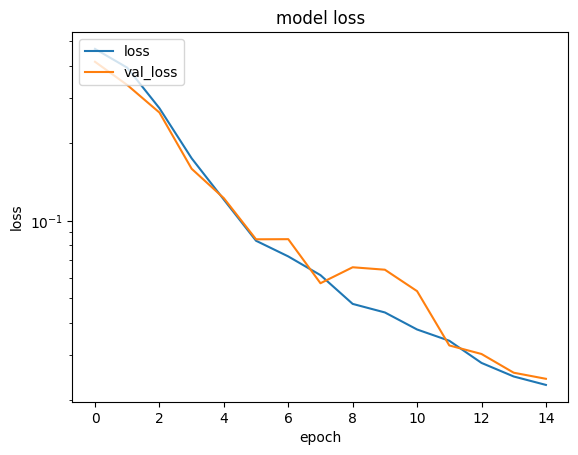

In [ ]:
if 'loss' not in locals():
    loss={}
for key in history.history:
    if 'loss' in key:
        loss[key] = np.append(loss.get(key,[]) , history.history[key])
        plt.semilogy(loss[key])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loss.keys(), loc='upper left')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('Test accuracy:', test_acc)

38/38 - 0s - loss: 0.0340 - accuracy: 0.9653 - 391ms/epoch - 10ms/step
Test accuracy: 0.9653465151786804


### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).
* Images, that have a bigger deviation as the parameter "deviation_max_list" are printed in a list to check the picture and labeling itself

In [ ]:
y_test_pred = model.predict(X_test, verbose=0)
y_test_true = y_test
target_pred = trig_to_target(y_test_pred)
target_true = trig_to_target(y_test_true)
dev_target = target_true-target_pred

## Results

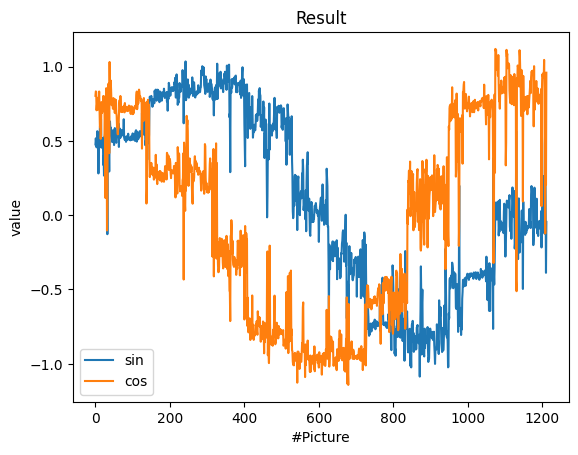

In [ ]:
plt.plot(y_test_pred[:,0])
plt.plot(y_test_pred[:,1])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

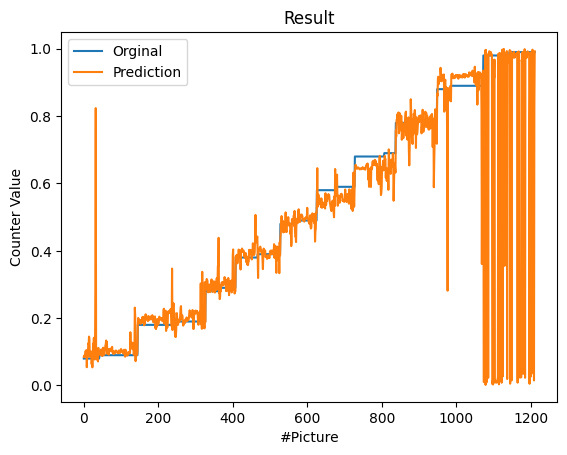

In [ ]:
plt.plot(target_true)
plt.plot(target_pred)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

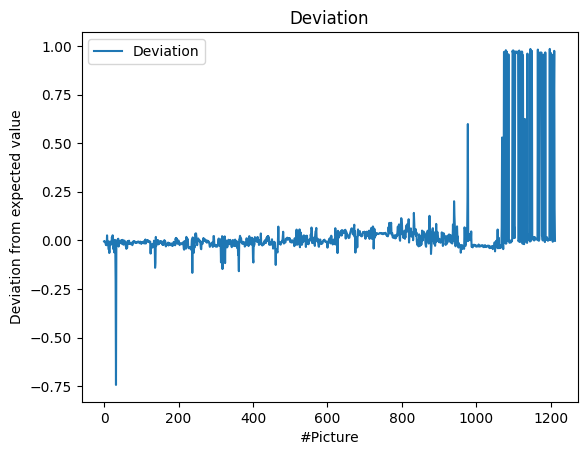

In [ ]:
plt.plot(dev_target[:])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [ ]:
blub


NameError: name 'blub' is not defined

In [ ]:
FileName = TFlite_MainType + "_" + TFlite_Version + "_" + TFlite_Size

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

In [ ]:
from pathlib import Path
import tensorflow as tf

FileName = FileName = TFlite_MainType + "_" + TFlite_Version + "_" + TFlite_Size + "_q.tflite"

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[n], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

In [ ]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

In [ ]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()


open(FileName + ".tflite", "wb").write(tflite_quant_model)